In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [3]:
#function to create the cost graph as well as fit and score the circuit on the given dataset

def fit_and_score(circuit_classifier, features, targets):
    plt.rcParams["figure.figsize"] = (12, 6)

    start_time = time.time()
    # fit classifier to data
    circuit_classifier.fit(features, targets)
    runtime = time.time() - start_time

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(features, targets)
    print('Score: ' + str(score))
    return score, runtime

#We will then normalize to -1 and 1, as those are opposing rotations when using an RY-Gate
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler(feature_range=(-1,1)).fit_transform(data)


In [4]:
# callback function that draws a live plot when the .fit() method is called

# saves the calculated weights
model_weights = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    model_weights.append(weights)

In [5]:
#As we can see we achieve perfect accuracy. 
#Apparently it seems to work, but what about a more complex dataset?
#One with 3 classes?
#For this we will use the IRIS dataset. Its been solved in a pletora of ways (SVM, NN etc.) so we have a good base to compare our results to

#Stats of the runtime for later comparison using plots
stats = []

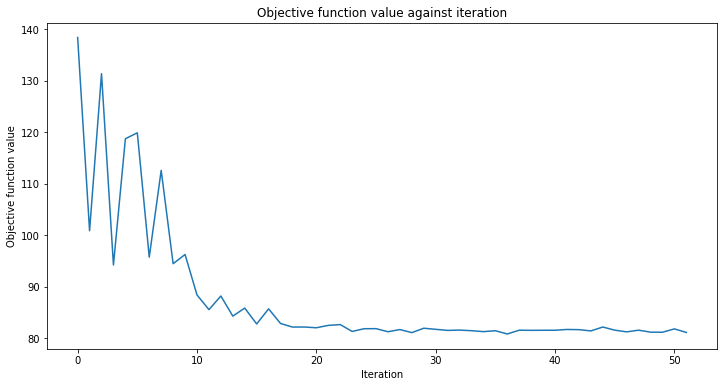

Score: 0.88


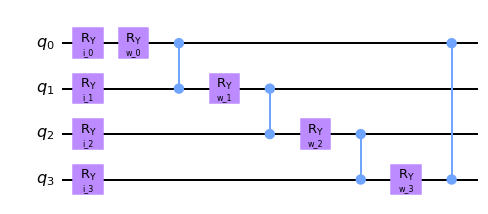

In [6]:
from sklearn.datasets import load_iris

#build simulator that does 1024 shots per run, so per featureset calculates the result 1024 times
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

#we need to update the parity function to resemble 3 classes
output_shape = 3  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    retVal = '{:b}'.format(x).count('1') % output_shape
    # print("parity {:b} => {}".format(x, retVal))
    return retVal

# Load the data and split it up
dataset = load_iris()
data = dataset['data']
#print("data", data)
targets = np.array(dataset['target'])
#print("targets", targets)

#normalize data between [-1,1]
normalized_features = np.array(normalize_data(data))
#print("normalized_features", normalized_features)

#we extend the successfull circuit from the XOR dataset to support 4 features and 4 weights

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))



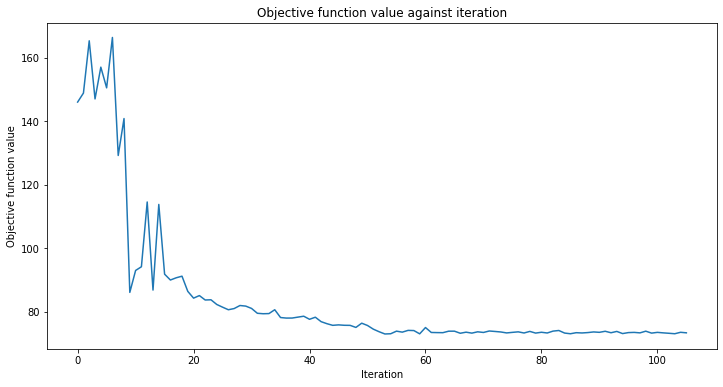

Score: 0.9133333333333333


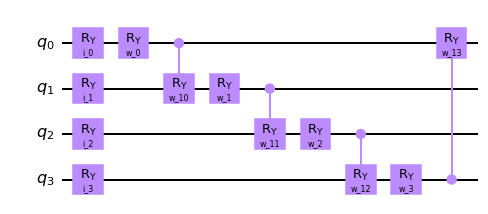

In [ ]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

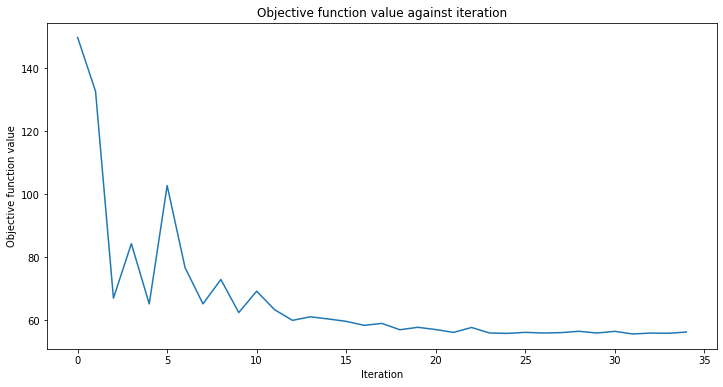

KeyboardInterrupt: 

In [9]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)

feature_map.ry(Parameter('i_0'),0)
feature_map.ry(Parameter('i_1'),0)
feature_map.ry(Parameter('i_3'),1)
feature_map.ry(Parameter('i_4'),1)

ansatz.ry(Parameter('w_0'),0)
ansatz.cry(Parameter('w_10'), 0, 1)
ansatz.ry(Parameter('w_1'),1)
ansatz.cry(Parameter('w_11'), 1, 0)

qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))


In [7]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)

# ----- state preparation
feature_map.ry(Parameter('i_0'),0)

feature_map.cx(0, 1)
feature_map.ry(Parameter('i_1'),1)
feature_map.cx(0, 1)
feature_map.ry(Parameter('i_2'),1)
feature_map.x(0)

feature_map.cx(0, 1)
feature_map.ry(Parameter('i_3'),1)
feature_map.cx(0, 1)
feature_map.ry(Parameter('i_4'),1)
feature_map.x(0)

# ----- layer 1
ansatz.rz(Parameter('w_0'),0)
ansatz.ry(Parameter('w_1'),0)
ansatz.rz(Parameter('w_2'),0)

ansatz.rz(Parameter('w_10'),1)
ansatz.ry(Parameter('w_11'),1)
ansatz.rz(Parameter('w_12'),1)

ansatz.cx(0, 1)

qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 5, but got: 4.'